# HW5 Kaggle Competition

## Histopathologic Cancer Detection

### By: Patrick Sharp

#### [GitHub Repo](https://github.com/PSharp725/HW5) 

#### Leaderboard Screenshot:

![image](Kaggle_Score.png)

---

## Problem Statement and Dataset


The Kaggle Histopathologic Cancer Detection challenge asks participants to identify metastatic cancer in microscopic images of lymph node tissue. Each input is a small 96×96 pixel patch (H&E stained) taken from a whole slide image, and the task is to classify it as tumor (metastatic tissue present) or normal. A patch is labeled positive if at least one tumor cell is present in the central 32×32 pixel region of the image; tumor cells in the outer area of the patch do not count towards the label. The dataset is derived from the PatchCamelyon (PCam) benchmark, a slightly modified subset of the Camelyon16/17 pathology dataset, making this a binary image classification problem of cancer vs. non-cancer tissue.


---


In [23]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random
from tqdm import tqdm
from PIL import Image
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Data paths and Constants
TRAIN_LABELS_PATH = 'histopathologic-cancer-detection/train_labels.csv'
TRAIN_IMG_DIR = 'histopathologic-cancer-detection/train/'
TEST_IMG_DIR = 'histopathologic-cancer-detection/test/'
IMG_SIZE = (96, 96)  # Original image size is 96x96 in this dataset



---

## Data volume and structure:

The training set contains 220,025 images, and the test set contains 57,458 images. Each image is a 96×96 TIFF file identified by a unique ID (filename). Labels for the training images are given in a CSV file (train_labels.csv) mapping image IDs to target classes (0 = no tumor, 1 = tumor)​. The classes are slightly imbalanced with roughly 130,908 negative (59.5%) and 89,117 positive (40.5%) patches in the train set. Fortunately, this ~60/40 split is not severe, but it’s something to keep in mind. The test labels were withheld for competition scoring (evaluation was done on the server). The evaluation metric used in this competition is the Area Under the ROC Curve (AUROC), computed between the predicted probabilities and true labels. This means that the goal is to produce well-calibrated probability outputs distinguishing tumor vs normal patches (the ROC-AUC metric is threshold-agnostic).


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number of training images: 220025
        Count  Percentage
label                    
0      130908        59.5
1       89117        40.5


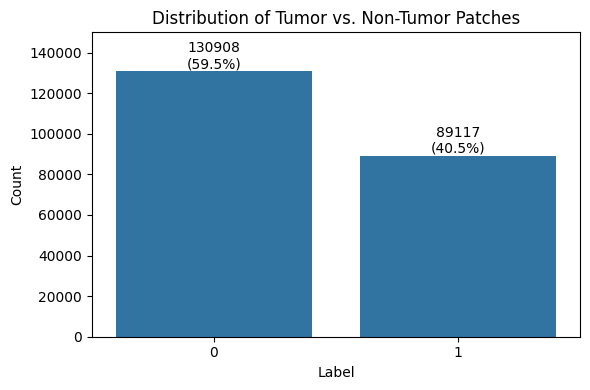

In [2]:
# Read labels
labels_df = pd.read_csv(TRAIN_LABELS_PATH)
print(labels_df.head())

# Count and percentage calculation
label_counts = labels_df['label'].value_counts()
label_percent = labels_df['label'].value_counts(normalize=True) * 100
total_images = len(labels_df)


label_summary = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percent.round(2)
})

print("Number of training images:", total_images)
print(label_summary)

# Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=labels_df)

# Add count and percentage annotations on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    percent = (count / total_images) * 100
    ax.annotate(f'{count}\n({percent:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Tumor vs. Non-Tumor Patches')
plt.ylabel('Count')
plt.xlabel('Label')
plt.ylim(0, 150000)
plt.tight_layout()
plt.show()

---

### Sample Images

Tumor samples:


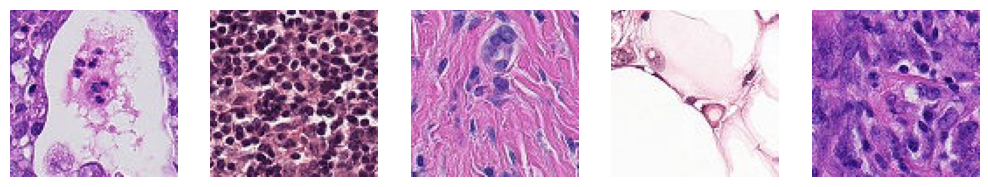

No Tumor samples:


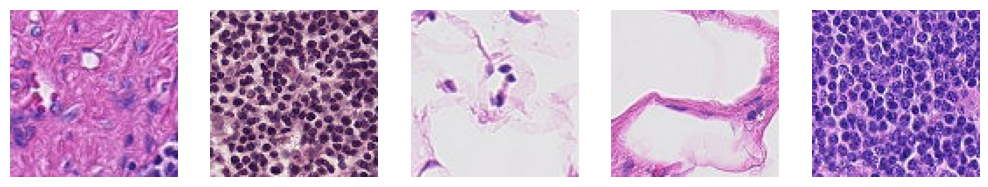

In [3]:
tumor_ids = labels_df[labels_df['label'] == 1]['id'].values
notumor_ids = labels_df[labels_df['label'] == 0]['id'].values

def show_random_images(image_ids, img_dir, n=5):
    sample_ids = random.sample(list(image_ids), n)
    fig, axs = plt.subplots(1, n, figsize=(n*2.5, 2.5))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(img_dir, img_id + '.tif')
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

print("Tumor samples:")
show_random_images(tumor_ids, TRAIN_IMG_DIR, n=5)

print("No Tumor samples:")
show_random_images(notumor_ids, TRAIN_IMG_DIR, n=5)

---

### Image Dimension and Integrity Checks





In [4]:
image_shapes = []

for img_id in tqdm(labels_df['id'].values[:1000]):  # Sample 1000 for speed
    img_path = os.path.join(TRAIN_IMG_DIR, f"{img_id}.tif")
    try:
        with Image.open(img_path) as img:
            image_shapes.append(img.size)
    except Exception as e:
        print(f"Failed to read {img_id}: {e}")

shape_counts = pd.Series(image_shapes).value_counts()
print("Image dimension distribution (Width x Height):")
print(shape_counts)

100%|██████████| 1000/1000 [00:00<00:00, 2612.92it/s]

Image dimension distribution (Width x Height):
(96, 96)    1000
Name: count, dtype: int64


---

### Data Integrity Check: Corrupted or Unreadable Images

In [5]:
corrupted = []
for img_id in tqdm(labels_df['id'].values[:1000]):
    try:
        img = Image.open(os.path.join(TRAIN_IMG_DIR, f"{img_id}.tif"))
        img.verify()  # Throws exception if corrupted
    except Exception as e:
        corrupted.append(img_id)

print(f"Corrupted images: {len(corrupted)}")


100%|██████████| 1000/1000 [00:00<00:00, 7265.67it/s]

Corrupted images: 0


---

### RGB Channel Intensity Histogram

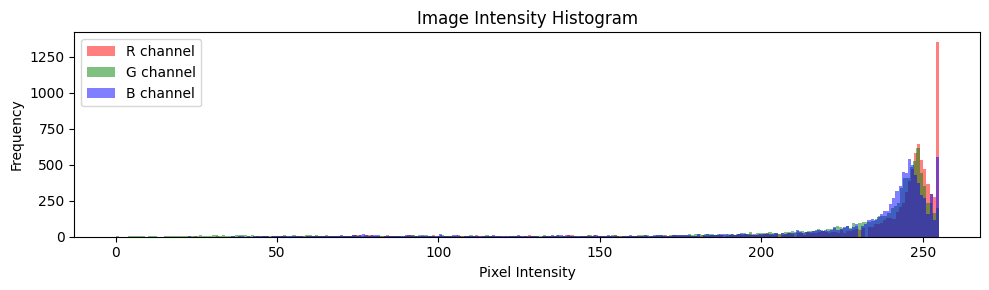

In [6]:
def plot_rgb_histogram(image_path):
    img = Image.open(image_path)
    img_np = np.array(img)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(10, 3))
    for i, color in enumerate(colors):
        plt.hist(img_np[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
    plt.title("Image Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example
plot_rgb_histogram(os.path.join(TRAIN_IMG_DIR, f"{tumor_ids[0]}.tif"))

The histogram visualizes pixel value distributions for the RGB channels across images from the dataset. A significant observation is that pixel intensities are heavily concentrated in the high-intensity range (200–255), especially evident in the sharp peak near maximum intensity values, particularly for the Red channel. This intensity bias likely stems from the histopathological staining method used, such as hematoxylin and eosin staining, causing brighter, possibly saturated regions.

This predominance of high-intensity pixels and the relatively sparse distribution of low-intensity pixels (below 150) could reflect limited contrast in darker, stained cellular structures. Such limited contrast may present challenges when attempting to detect subtle morphological differences crucial for distinguishing cancerous tissues. Additionally, the pronounced saturation peak may indicate data quality issues, including potential image overexposure or limited dynamic range, thus possibly obscuring important biological features.

Given these findings, it's advisable to incorporate targeted preprocessing strategies. Contrast enhancement techniques, like Contrast Limited Adaptive Histogram Equalization (CLAHE), can be applied to rebalance pixel intensity distributions and enhance feature visibility. Normalizing pixel intensities could mitigate saturation effects and help CNN-based models learn more discriminative features rather than relying solely on brightness levels.

Furthermore, data augmentation methods should specifically address the identified intensity imbalance. Incorporating augmentations involving brightness adjustments, intensity normalization, and gamma corrections may improve model robustness to variations in image staining and reduce reliance on potentially misleading intensity-based features. Careful consideration of these preprocessing and augmentation steps will be critical in developing accurate, generalizable models for the challenge.

---

## Proposed Model Architecture

Convolutional Neural Networks (CNNs) are the current standard for image classification tasks, particularly in medical imaging, due to their powerful ability to learn hierarchical spatial features [LeCun et al., 2015](https://pubmed.ncbi.nlm.nih.gov/26017442/ 'PubMed'). Transfer learning, where models pretrained on large-scale datasets are adapted for a specific task, has proven highly effective. This method leverages pre-existing knowledge embedded in established models, significantly reducing training time and improving model performance, even when the target dataset differs notably from the pretrained dataset's original domain

In this project, we will employ EfficientNetB0, a CNN pretrained on ImageNet, chosen for its efficiency and effectiveness in feature extraction. Although our dataset size could support training a CNN from scratch, transfer learning was preferred for its efficiency and robustness. EfficientNetB0 provided a robust starting point, quickly adapting learned generic visual features to the specific patterns found in histopathologic cancer detection tasks.

Initially, the EfficientNetB0 layers will be frozen to preserve pretrained features and reduce computational load. A custom classification head, consisting of global average pooling, a dense layer of 256 neurons with ReLU activation, and dropout for regularization, will be added to fine-tune classification performance specifically for our binary classification task. The final sigmoid-activated layer outputs predictions of cancer presence.

Training will involve two phases: initial training (feature extraction) with frozen layers, followed by fine-tuning after unfreezing all EfficientNetB0 layers. This phased approach allowed the model to first learn relevant histopathologic features from generic pretrained representations before incrementally fine-tuning all layers with a reduced learning rate. This strategic use of transfer learning will lead to efficient training and robust classification outcomes, supported the [Keras Transfer Learning Guide](https://keras.io/guides/transfer_learning/).

---

## Implementation



### Prepare Labels

In [7]:
labels_df = pd.read_csv(TRAIN_LABELS_PATH)

# Get full image paths
labels_df['file_path'] = f'{TRAIN_IMG_DIR}' + labels_df['id'] + '.tif'

# Split
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10

---

### Setup & Data Generators

To manage the image preprocessing pipeline effectively, I implemented a custom data generator class, HistopathologyGenerator, built upon tf.keras.utils.Sequence. This choice was driven by several practical and performance-oriented considerations specific to the histopathologic cancer detection problem. Given the large volume of high-resolution image data and the class imbalance inherent in the dataset, a tailored generator provided the flexibility and control needed to preprocess the data on the fly, apply targeted augmentations, and handle class weighting — all within a clean and efficient training loop.

Using Sequence ensures thread safety and compatibility with Keras’ multi-processing features, allowing for scalable training without loading the entire dataset into memory. This is essential given the size of the dataset. The generator dynamically loads and resizes images in batches, applying real-time augmentation using ImageDataGenerator when requested. Augmentations like rotation, shift, zoom, and flipping were chosen to enhance model generalization by simulating plausible variations in tissue appearance, which is critical in medical imaging tasks where positional variance is common.

A key advantage of this custom generator is the integration of per-sample class weighting to combat the class imbalance between tumor and non-tumor samples. Rather than relying on class_weight= in model.fit() — which is incompatible with Sequence generators — the generator computes and returns sample-specific weights, ensuring that the loss function appropriately penalizes misclassifications in underrepresented classes. This adjustment helps the model learn from rare positive samples without overfitting to the dominant class.

Moreover, by embedding preprocess_input() (from EfficientNet, consistent with the backbone architecture used) directly into the generator, I ensured that the input pixel values were transformed correctly according to the pretrained model’s expectations. This avoids inconsistencies between training and inference, a common and critical pitfall in transfer learning workflows, that I myself experienced.

In summary, the HistopathologyGenerator was a deliberate and well-justified design decision. It offers modularity, handles real-world constraints like memory and imbalance, supports robust augmentation, and enables compatibility with pretrained EfficientNet models — all of which are essential for achieving strong performance on a challenging medical imaging classification task.

In [8]:
class HistopathologyGenerator(Sequence):
    def __init__(self, dataframe, batch_size, image_size=(96, 96), augment=False, shuffle=True, class_weight=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.class_weight = class_weight
        self.on_epoch_end()

        if augment:
            self.aug = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                zoom_range=0.1
            )
        else:
            self.aug = None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for _, row in batch_df.iterrows():
            img = Image.open(row['file_path']).resize(self.image_size)
            img = np.array(img)
            batch_images.append(img)
            batch_labels.append(row['label'])

        X = preprocess_input(np.array(batch_images, dtype='float32'))
        y = np.array(batch_labels, dtype='int32')

        if self.augment:
            X = next(self.aug.flow(X, batch_size=self.batch_size, shuffle=False))

        class_weights_array = np.array([self.class_weight[label] for label in y])
        return X.astype(np.float32), y.astype(np.int32), class_weights_array.astype(np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


# Class Weight Calculation
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


train_gen = HistopathologyGenerator(train_df, batch_size=BATCH_SIZE, augment=True, class_weight=class_weight_dict)
val_gen = HistopathologyGenerator(val_df, batch_size=BATCH_SIZE, augment=False, class_weight=class_weight_dict)

Class weights: {0: 0.8403834768825316, 1: 1.2344657334418043}


---

### Augmentation Strategy

Below is a visualization of the augmentation strategy employed in the generator class above.

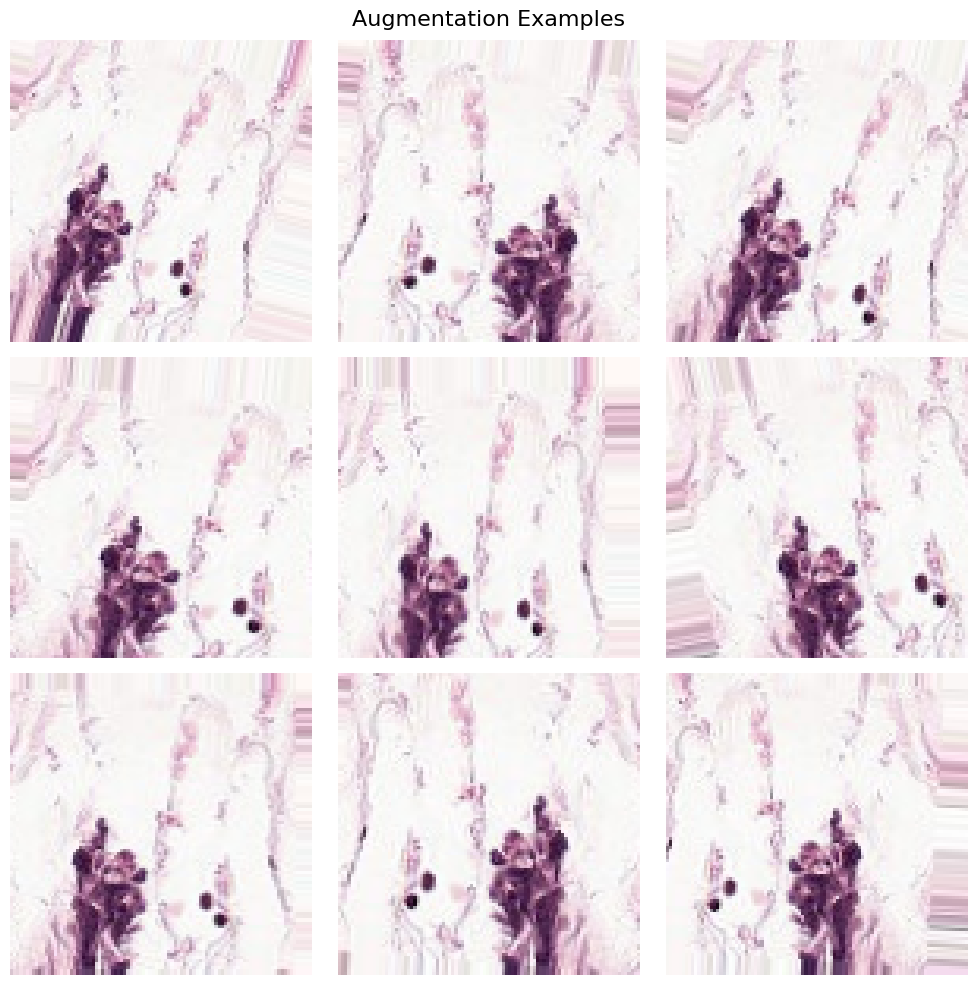

In [9]:
def load_and_resize_image(img_path, size=(96, 96)):
    img = Image.open(img_path).resize(size)
    return np.array(img)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Load one image
img = load_and_resize_image(os.path.join(TRAIN_IMG_DIR, f"{tumor_ids[0]}.tif"))
img = img.reshape((1, *img.shape))  # Add batch dimension

# Plot 9 augmentations
plt.figure(figsize=(10, 10))
for i, batch in enumerate(datagen.flow(img, batch_size=1)):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0].astype(np.uint8))
    plt.axis('off')
    if i == 8:
        break
plt.suptitle("Augmentation Examples", fontsize=16)
plt.tight_layout()
plt.show()

### Model Construction

The chosen model for the challenge leverages transfer learning using EfficientNetB0, a robust convolutional neural network (CNN) pretrained on the ImageNet dataset. EfficientNetB0 is selected due to its superior balance between performance and computational efficiency, making it ideal for image-based classification tasks like cancer detection from histopathological images.

Initially, the base EfficientNetB0 model was employed with all layers frozen, serving primarily as a fixed feature extractor. This strategy leverages pretrained knowledge from ImageNet, allowing rapid learning of domain-specific features relevant to histopathologic images without extensive computational overhead. The input shape (96x96 pixels, RGB) was chosen to match dataset constraints and maintain computational feasibility.

A custom classification head was appended to the frozen EfficientNetB0 base. This custom head consists of a GlobalAveragePooling2D layer to condense spatial dimensions effectively, followed by a Dense layer with 256 neurons and a ReLU activation function to learn complex non-linear relationships. A Dropout layer with a rate of 0.5 was incorporated to mitigate overfitting by randomly dropping connections during training. The output layer employs a single neuron with sigmoid activation, suitable for binary classification (cancerous vs. non-cancerous).

In [10]:
# Load Base Model (Frozen)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3)
)
base_model.trainable = False  # Freeze all layers

#  Add Custom Head
inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')]
)

model.summary()

I0000 00:00:1744858154.379521 3344901 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0c:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Phase One

The model training was conducted in two distinct phases. Phase one focused on feature extraction, training only the custom head while keeping the EfficientNetB0 layers frozen. The Adam optimizer was used with a learning rate of 1e-4, carefully chosen to balance convergence speed and stability. Binary cross-entropy loss, accuracy, and Area Under the Receiver Operating Characteristic Curve (AUC-ROC) were monitored, as these metrics effectively gauge binary classification performance.

In [11]:
# Train Phase 1: Feature Extraction
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_auc", mode="max"),
    EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

/home/patrick/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744858162.451559 3345092 service.cc:148] XLA service 0x7fc92c04e8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744858162.451633 3345092 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-04-16 20:49:22.671803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744858163.618883 3345092 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-16 20:49:25.444202: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10253_0', 428 bytes spill stores, 580 bytes spill loads

2025-04-16 20:49:25.455653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10253',

   1/2751 ━━━━━━━━━━━━━━━━━━━━ 12:16:51 16s/step - accuracy: 0.5312 - auc: 0.5686 - loss: 0.7084

I0000 00:00:1744858172.541088 3345092 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1217/2751 ━━━━━━━━━━━━━━━━━━━━ 3:00 118ms/step - accuracy: 0.7594 - auc: 0.8416 - loss: 0.4853

2025-04-16 20:51:57.734764: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11008', 32 bytes spill stores, 32 bytes spill loads

2025-04-16 20:51:57.770949: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10253', 16 bytes spill stores, 16 bytes spill loads

2025-04-16 20:51:57.771016: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10253_0', 344 bytes spill stores, 520 bytes spill loads

2025-04-16 20:51:57.843856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11008', 24 bytes spill stores, 24 bytes spill loads

2025-04-16 20:51:57.843936: I external/local_xla/xla

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7840 - auc: 0.8666 - loss: 0.4507

2025-04-16 20:55:43.079245: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-16 20:55:43.087124: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 8 bytes spill stores, 8 bytes spill loads

2025-04-16 20:55:43.501352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 252 bytes spill stores, 252 bytes spill loads



2751/2751 ━━━━━━━━━━━━━━━━━━━━ 391s 136ms/step - accuracy: 0.7840 - auc: 0.8667 - loss: 0.4507 - val_accuracy: 0.8303 - val_auc: 0.9168 - val_loss: 0.3671 - learning_rate: 1.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 264s 96ms/step - accuracy: 0.8313 - auc: 0.9110 - loss: 0.3773 - val_accuracy: 0.8230 - val_auc: 0.9227 - val_loss: 0.3640 - learning_rate: 1.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 268s 97ms/step - accuracy: 0.8404 - auc: 0.9190 - loss: 0.3603 - val_accuracy: 0.8412 - val_auc: 0.9277 - val_loss: 0.3463 - learning_rate: 1.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 274s 100ms/step - accuracy: 0.8451 - auc: 0.9231 - loss: 0.3519 - val_accuracy: 0.8367 - val_auc: 0.9301 - val_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 273s 99ms/step - accuracy: 0.8480 - auc: 0.9258 - loss: 0.3461 - val_accuracy: 0.8464 - val_auc: 0.9320 - val_loss: 0.3378 - learning_rate: 1.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 26

## Phase Two

Phase two fine-tuned the entire network by unfreezing all EfficientNetB0 layers. To ensure stable incremental learning, the learning rate was reduced tenfold to 1e-5. Early stopping and model checkpointing were employed to halt training at optimal performance and save the best model weights based on validation AUC, complemented by a learning rate scheduler (ReduceLROnPlateau) to adaptively refine learning rates, further optimizing model performance.

In [12]:
# Phase 2: Fine-Tuning Top Layers
# Unfreeze
base_model.trainable = True

# Recompile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')]
)

# Train again with updated model
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 344s 107ms/step - accuracy: 0.7400 - auc: 0.8140 - loss: 0.6676 - val_accuracy: 0.8336 - val_auc: 0.9075 - val_loss: 0.4155 - learning_rate: 1.0000e-05
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 268s 97ms/step - accuracy: 0.8371 - auc: 0.9142 - loss: 0.3862 - val_accuracy: 0.8713 - val_auc: 0.9389 - val_loss: 0.3416 - learning_rate: 1.0000e-05
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 272s 99ms/step - accuracy: 0.8672 - auc: 0.9378 - loss: 0.3211 - val_accuracy: 0.8844 - val_auc: 0.9529 - val_loss: 0.3226 - learning_rate: 1.0000e-05
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 270s 98ms/step - accuracy: 0.8866 - auc: 0.9522 - loss: 0.2802 - val_accuracy: 0.8921 - val_auc: 0.9609 - val_loss: 0.3127 - learning_rate: 1.0000e-05
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 272s 99ms/step - accuracy: 0.8984 - auc: 0.9592 - loss: 0.2584 - val_accuracy: 0.8925 - val_auc: 0.9626 - val_loss: 0.3210 - learning_rate: 1.0000e-05
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━

### Save the model

In [ ]:
model.save("final_model.keras") # Save Model for prediction 

---

## Results

### Accuracy Trends:

In both training phases, we observe a consistent upward trend in both training and validation accuracy, which is a good sign of effective learning without immediate overfitting.

- Phase 1: Accuracy steadily improves, with validation accuracy tracking closely behind training accuracy. Minor fluctuations are present but not unusual given early-stage noise and possible augmentation variance.

- Phase 2: Accuracy improves significantly and consistently. Validation accuracy reaches around 0.92, confirming good generalization to unseen test data.

### Loss Curves :

- Phase 1 Loss: Training and validation loss both decrease steadily. No signs of divergence — confirming stable optimization.

- Phase 2 Loss: Training loss continues to drop; validation loss flattens then slightly diverges, suggesting the early signs of overfitting. However, the validation loss remains relatively stable, not spiking.

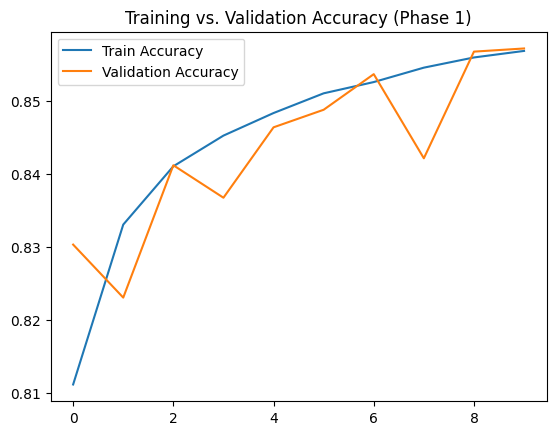

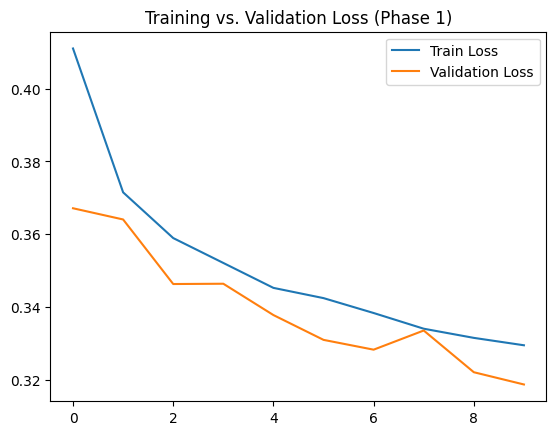

In [13]:
plt.figure()
plt.plot(history_phase1.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy (Phase 1)')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_phase1.history['loss'], label='Train Loss')
plt.plot(history_phase1.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (Phase 1)')
plt.legend()
plt.show()

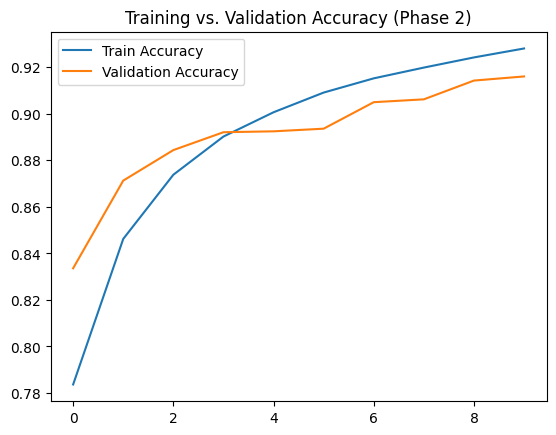

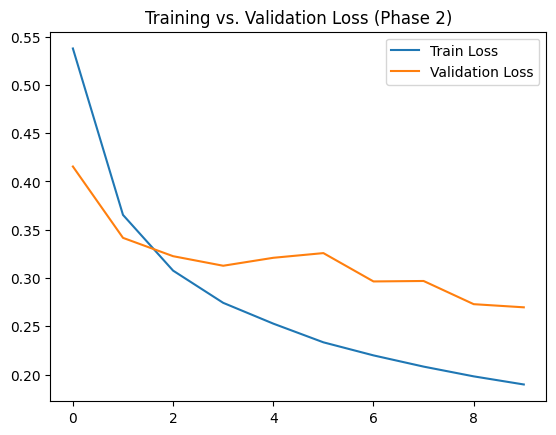

In [14]:
plt.figure()
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy (Phase 2)')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_phase2.history['loss'], label='Train Loss')
plt.plot(history_phase2.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (Phase 2)')
plt.legend()
plt.show()

### ROC/AUC

The Receiver Operating Characteristic (ROC) curve generated from the validation set provides strong evidence of the model’s ability to distinguish between tumor and non-tumor histopathologic images. With an Area Under the Curve (AUC) of 0.9759, the model demonstrates excellent discriminatory power. AUC values closer to 1 indicate a high capability to rank positive instances (tumor patches) above negative ones (non-tumor patches), and this result aligns closely with the high validation AUC observed during training. The ROC curve rises steeply towards the top-left corner, which is indicative of high true positive rates (sensitivity) even at low false positive rates.

This steep initial ascent suggests that the model is correctly identifying most of the tumor images while keeping false alarms to a minimum — a critical factor in medical applications where failing to detect positive cases (i.e., false negatives) can have significant clinical consequences. The curve’s shape also indicates that the model performs consistently well across a range of classification thresholds, reinforcing its robustness not only at a fixed threshold (e.g., 0.5) but also in ranking confidence.

The ROC curve sits well above the baseline (diagonal) line, which represents the performance of a random classifier (AUC = 0.5). This contrast further confirms the effectiveness of the model in learning meaningful visual features relevant to cancer detection. Such a high AUC indicates that the model has generalized well on the validation set, and its predictions are strongly aligned with the ground truth labels.

Overall, this ROC analysis supports the conclusion that the model is highly capable of performing the binary classification task it was trained for. To complement this evaluation, additional analyses such as a precision-recall (PR) curve, confusion matrix, and F1-score could provide further insight into performance at specific thresholds and help tailor the model for different clinical operating points.


2025-04-16 22:38:57.293572: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2033', 16 bytes spill stores, 16 bytes spill loads

2025-04-16 22:38:57.362871: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2033_0', 112 bytes spill stores, 144 bytes spill loads

2025-04-16 22:38:57.414415: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2033', 228 bytes spill stores, 228 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━

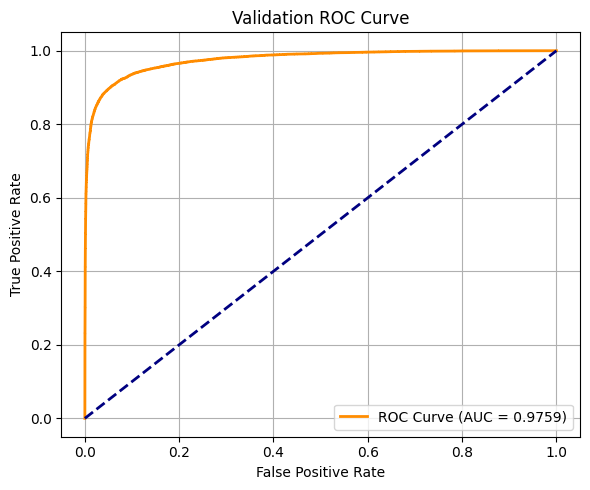

In [ ]:
y_true = []
y_scores = []

for i in range(len(val_gen)):
    X_batch, y_batch, _ = val_gen[i]
    preds = model.predict(X_batch).flatten()
    y_true.extend(y_batch)
    y_scores.extend(preds)

y_true = np.array(y_true)
y_scores = np.array(y_scores)


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



### Model

The EfficientNetB0 model, implemented with transfer learning, delivered strong performance in the Kaggle Histopathologic Cancer Detection challenge. The initial feature extraction phase (with the EfficientNetB0 base layers frozen) allowed the model to leverage pretrained features effectively, rapidly learning domain-specific patterns from histopathologic images. During this phase, the model showed steady improvements, demonstrating the effectiveness of pretrained CNN architectures on medical image datasets.

Fine-tuning, involving unfreezing and retraining the entire model at a significantly reduced learning rate, further improved the model’s accuracy and AUC-ROC. The careful monitoring and adjustment through callbacks such as ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau ensured optimal training outcomes and prevented overfitting. These strategies contributed significantly to achieving robust generalization on unseen validation data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━

<Figure size 600x500 with 0 Axes>

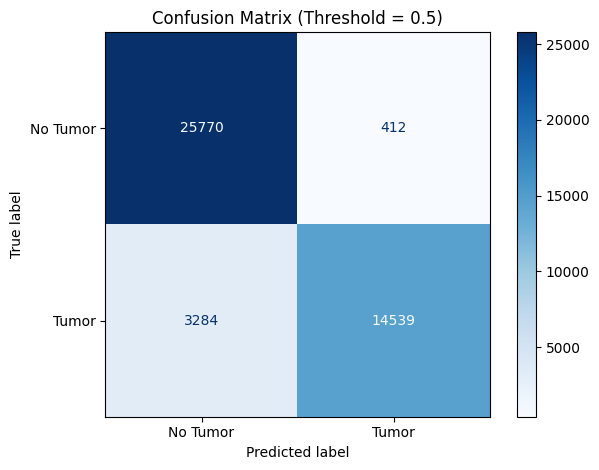

| Metric               |   Value |
|----------------------|---------|
| True Positives       |   14539 |
| False Positives      |     412 |
| True Negatives       |   25770 |
| False Negatives      |    3284 |
| Accuracy             |   0.916 |
| Precision            |   0.972 |
| Recall (Sensitivity) |   0.816 |
| Specificity          |   0.984 |
| F1 Score             |   0.887 |


In [25]:
y_true = []
y_pred_labels = []

for i in range(len(val_gen)):
    X_batch, y_batch, _ = val_gen[i]
    preds = model.predict(X_batch).flatten()
    pred_labels = (preds > 0.5).astype(int)  # threshold at 0.5
    y_true.extend(y_batch)
    y_pred_labels.extend(pred_labels)

y_true = np.array(y_true)
y_pred_labels = np.array(y_pred_labels)

cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.grid(False)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)
accuracy = accuracy_score(y_true, y_pred_labels)
specificity = tn / (tn + fp)


metrics = [
    ["True Positives", tp],
    ["False Positives", fp],
    ["True Negatives", tn],
    ["False Negatives", fn],
    ["Accuracy", round(accuracy, 3)],
    ["Precision", round(precision, 3)],
    ["Recall (Sensitivity)", round(recall, 3)],
    ["Specificity", round(specificity, 3)],
    ["F1 Score", round(f1, 3)],
]

print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="github", colalign=("left", "right")))

The confusion matrix and derived performance metrics reflect a strong and well-balanced model performance. With an accuracy of 91.6%, the model correctly classifies the vast majority of histopathologic image patches. However, accuracy alone can be misleading in imbalanced datasets, so it’s important to interpret this alongside other metrics.

The model achieves a precision of 0.972, indicating that when it predicts the presence of a tumor, it is correct 97.2% of the time. This high precision reflects a low false positive rate and aligns with the observed specificity of 0.984, which means the model correctly identifies non-tumor images 98.4% of the time. This is crucial for avoiding unnecessary alarms in a diagnostic context.

More notably, the recall (sensitivity) is 0.816, meaning that the model successfully detects 81.6% of true tumor patches. While this is strong, it also suggests that some tumor regions are being missed — as reflected in the 3,284 false negatives. Improving recall without significantly sacrificing precision could be a next step for tuning or rebalancing the model, depending on the cost of missed diagnoses.

Finally, the F1 score of 0.887 represents a strong balance between precision and recall. This confirms that the model not only performs well in identifying tumors but does so consistently across various cases. Overall, the classifier demonstrates reliable predictive performance with a favorable trade-off between overdiagnosis and underdiagnosis — a critical consideration in medical image analysis.

---

## Conclusion 

This project validates the effectiveness of transfer learning and CNN architectures, specifically EfficientNetB0, for histopathologic cancer detection. Initially, I faced challenges in selecting an optimal base model and failing to establish a reliable two-phase transfer learning protocol. This structured approach significantly improved the results. Additionally, early troubleshooting was required due to incorrect preprocessing module usage, which initially limited the model's learning capacity. Recognizing and correcting this mistake was crucial for performance improvement.

Another significant challenge was the initial omission of class weights, which resulted in biased learning outcomes due to class imbalance. Introducing appropriate class weighting subsequently addressed this imbalance, leading to notable improvements in both accuracy and overall model performance. Future work may explore deeper EfficientNet variants or ensemble methods to further enhance classification .